# Classification of Cats and Dogs
In this notebook, classification between images of cats and dogs is done using transfer learning. The dataset can be acquired through [this link](https://www.kaggle.com/tongpython/cat-and-dogThe). Resnet50 model for PyTorch has been used. All architecture except the last layer is fixed. The last layer is modified for two classes. With very less epoch very good accuracy can be achieved.

## Importing libraries

In [10]:
from google.colab import drive # for Google Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

input_path = "/content/drive/My Drive/Colab Notebooks/cat-and-dog" 

In [12]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + '/training_set/training_set', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + '/test_set/test_set', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0), 
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0) 
}

## Selecting GPU if available

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

## Training

In [18]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [19]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.1142, acc: 0.9548
Epoch 2/3
----------
train loss: 0.0901, acc: 0.9638
Epoch 3/3
----------
train loss: 0.0829, acc: 0.9691


In [ ]:
!mkdir models
!mkdir models/pytorch

In [21]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

Thanks to ResNet, accuracy of >95% was easily achieved. Further training seemed to be ineffecient.

## Creating a Model for Testing

In [22]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

<All keys matched successfully>

## Showing Test Samples

In [24]:
validation_img_paths = ["/test_set/test_set/cats/cat.4001.jpg",
                        "/test_set/test_set/cats/cat.4003.jpg",
                        "/test_set/test_set/dogs/dog.4004.jpg",
                       "/test_set/test_set/dogs/dog.4006.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [25]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [26]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 2.7679, -4.4669],
        [ 3.8460, -6.0761],
        [-4.5956,  3.3232],
        [-4.6548,  2.8022]], device='cuda:0', grad_fn=<AddmmBackward>)

In [27]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.9927944e-01, 7.2054542e-04],
       [9.9995089e-01, 4.9075381e-05],
       [3.6371956e-04, 9.9963629e-01],
       [5.7704229e-04, 9.9942303e-01]], dtype=float32)

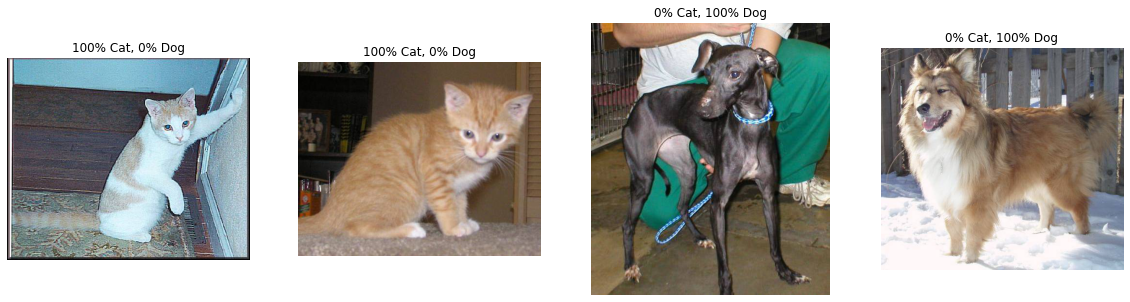

In [28]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Cat, {:.0f}% Dog".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

The model accurately classified four samples of pictures. 



## Confusion Matrix

In [29]:
labels_input=[]
labels_output=[]
def test_model(model, criterion, optimizer, num_epochs=1):
    for phase in ['validation']:
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input.append(labels)

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output.append(preds)
            
            
test_model(model, criterion, optimizer, num_epochs=1)

In [30]:
y_pred=(torch.cat(labels_output))
y_pred=y_pred.cpu().numpy()


y_true=(torch.cat(labels_input))
y_true=y_true.cpu().numpy()


from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[999,  12],
       [ 17, 995]])

Out of 2023 test inputs, the model made only 29 mistakes of misclassifying cats and dogs. Thus, the model successfully distinguished the pictures of cats and dogs from each other.